# Create a CASSIE dataset
with the settings found reasonable in cassie_sensitivity_analysis.ipynb

**Datasets this notebook expects to find** under the below given datapaths:
- 4 folders under `datapath_cassie`, each containing a file `coastlines.shp` (output of Cassie webinterface application):
    - `12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/`
    - `13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/`
    - `18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/`
    - `17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/`
- File `jarkus_transects_EPSG32631_reduced.geojson` in folder `datapath_jarkus'`
- File `TG_rijkswaterstaat_1992_01_01-2021_12_31.csv` in folder `datapath_northseaTG`
- File `transect_red_with_derivatives.nc` in folder `datapath_jarkus`

Files that are **created** in this notebook (in case they don't exist):
- `cd_cassie.pkl` in folder `datapath_cassie` (uncorrected intersections between shorelines and transects)
- `sl_cassie_red_tides.pkl` in folder `datapath_cassie` (uncorrected intersections reduced to the TG timeperiod)
- `beach_slope_cassie.pkl` in folder `datapath_cassie` (time- and space-variable beach slope around the shoreline)
- `cd_cassie_tcorr.pkl` in folder `datapath_cassie` (corrected cross-shore timeseries)

In [1]:
main_datapath = '/media/bene/Seagate/PhD-data/'
datapath_cassie = main_datapath + '10_RS_images/4_CASSIE/'
datapath_jarkus_transects = main_datapath + '4_land_elevation/2_JARKUS/exported_transects/'
datapath_jarkus = main_datapath + '4_land_elevation/2_JARKUS/'
datapath_northseaTG = main_datapath + '6_tide_gauge/2_Ters-North_Sea_rijkswaterstaat/'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import shapefile
import pandas as pd
import statistics
import numpy as np
import xarray as xr
import os
import pickle

# plotting
import matplotlib.pyplot as plt
from matplotlib import cm

# toolboxes
import sys
sys.path.append('/home/bene/PhD-git/70_CoastSat')
from coastsat import SDS_tools, SDS_transects

from coastal_data import CD_statistics, CD_helper_functions

# projection
from pyproj import CRS, Transformer

import pdb

## Load data

In [3]:
# Foldernames to the CASSIE shape files
folders = ['12_cassie_landsat_1984-04-30_1992-09-04_ext1000_spac5000_base2_multi-thresh/',\
          '13_cassie_landsat_1992-09-20_2003-08-02_ext1000_spac5000_base2_multi-thresh/',\
          '18_cassie_landsat_2003-09-19_2015-03-12_ext1300_spac5000_base1_multi-thresh/',\
          '17_cassie_landsat_2015-04-13_2023-02-22_ext1300_spac5000_base1_multi-thresh/']
fn = 'coastlines'

# Transformation from EPSG 4326 to EPSG 32631
crs_4326 = CRS.from_epsg(4326)
crs_32631 = CRS.from_epsg(32631)
transformer = Transformer.from_crs(crs_4326, crs_32631)

datelist = []
sllist = []

for folder in folders:
    sf = shapefile.Reader(datapath_cassie + folder + fn)    
    shorelines = sf.shapeRecords().__geo_interface__ # shapefile to geojson
    for sl in shorelines['features']:
        date = pd.to_datetime(sl['properties']['date'], utc=True)
        date = date.to_pydatetime()
        datelist.append(date)

        sl_4326 = sl['geometry']['coordinates']
        sl_23631 = [transformer.transform(_[1], _[0]) for _ in sl_4326]
        sllist_temp = [list(_) for _ in sl_23631]

        sllist.append(np.array(sllist_temp))
        
# put the dates and shoreline coordinates in a dictionary (CoastSat-output-like)
sl_cassie = {'dates' : datelist, 'shorelines' : sllist}

## Load transects

In [4]:
# JARKUS-transects
fn = 'jarkus_transects_EPSG32631_reduced.geojson'
geojson_file = datapath_jarkus_transects + fn
transects = SDS_tools.transects_from_geojson(geojson_file)

152 transects have been loaded


## Settings for timeseries

In [5]:
settings_ts = { # parameters for analysis of cross-shore time series
    'along_dist': 1200,    # along-shore distance to use for computing the intersection
    'sm_window_size' : 5, # window size for smoothing
    # tidal correction
    'beach_slope' : 'variable_median', #  number (= uniform beach slope), 'variable_median' or 'variable_mean'
    'grad_buffer' : 45, # [m], 1/2 length of the zone where the gradients in each point are considered for mean or median
    'water_levels_source' : 'tg', #'tg' or 'eot'
    'tide_corr_thresh' : 100, # [m], threshold for maximum tidal correction     
                    }

## Compute intersections

In [7]:
if not os.path.isfile(datapath_cassie + 'cd_cassie.pkl'):
    settings_transects = { # parameters for computing intersections
                  'along_dist': settings_ts['along_dist'],    # along-shore distance to use for computing the intersection
                  'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                  'max_std':             15,        # max std for points around transect
                  'max_range':           30,        # max range for points around transect
                  'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                  'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                  'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                  'max_dist_origin':      10000,     # maximum distance to the origin of a transect in [m]
                }
    cd_cassie = SDS_transects.compute_intersection_QC(sl_cassie, transects, settings_transects)

    # Interpolate over the nans
    for key in cd_cassie.keys():
        cd_cassie[key] = np.array(pd.Series(cd_cassie[key]).interpolate())

    # Smoothing
    cd_cassie_sm = {}
    for key in cd_cassie.keys():
        cd_cassie_sm[key] = CD_statistics.moving_average(cd_cassie[key], settings_ts['sm_window_size'])

    pickle.dump(cd_cassie_sm, open(datapath_cassie + 'cd_cassie.pkl', 'wb'))
else:
    cd_cassie_sm = pickle.load(open(datapath_cassie + 'cd_cassie.pkl', 'rb'))

/home/bene/PhD-git/1_gitlab_phd-project-bene/envs/coastsat/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bene/PhD-git/1_gitlab_phd-project-bene/envs/coastsat/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/bene/PhD-git/70_CoastSat/coastsat/SDS_transects.py:341: RuntimeWarning: All-NaN slice encountered
  max_intersect[i] = np.nanmax(xy_rot[0,:])
/home/bene/PhD-git/70_CoastSat/coastsat/SDS_transects.py:342: RuntimeWarning: All-NaN slice encountered
  min_intersect[i] = np.nanmin(xy_rot[0,:])


## Tidal correction

### Water levels

In [8]:
# get tide gauge data (North Sea)
data = pd.read_csv(datapath_northseaTG + 'TG_rijkswaterstaat_1992_01_01-2021_12_31.csv', index_col='datetime[utc]', \
                  parse_dates=['datetime[utc]'])
tides_ts = np.array(data['ssh[cm]']) / 100 # [m]

dates_ts = CD_helper_functions.datetime_to_decimal_numbers(data.index)
dates_cassie = CD_helper_functions.datetime_to_decimal_numbers(pd.to_datetime(sl_cassie['dates']))

# reduce SDS-timeseries to the timespan where tide gauge data is available
idx_tides_cassie = np.where((np.array(dates_cassie) < dates_ts[-1]) & (np.array(dates_cassie) > dates_ts[0]))[0]
dates_cassie = dates_cassie[idx_tides_cassie]

tides_cassie = np.interp(dates_cassie, dates_ts, tides_ts)

# reduce cross_distance and sl_dict to the timespan where tide data is available
cd_cassie_red_tides = {}
for key in cd_cassie_sm.keys():
    cd_cassie_red_tides[key] = cd_cassie_sm[key][idx_tides_cassie]

# sl_dict_red_tides
sl_cassie_red_tides = {}
sl_cassie_red_tides['dates'] = np.array(sl_cassie['dates'], dtype=object)[idx_tides_cassie]
sl_cassie_red_tides['shorelines'] = np.array(sl_cassie['shorelines'], dtype=object)[idx_tides_cassie]

pickle.dump(sl_cassie_red_tides, open(datapath_cassie + 'sl_cassie_red_tides.pkl', 'wb'))

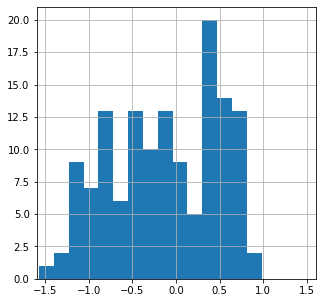

In [9]:
# water level histogram
plt.figure(figsize=(5,5))
# plt.plot(tides_cassie, '.')
plt.hist(tides_cassie, bins=15)
# plt.ylim([-1,1])
plt.xlim([-1.6, 1.6])
plt.grid()

In [10]:
print('average water level at time of image acquitision', np.nanmean(tides_cassie))
print('average water level over the entire time period', np.nanmean(data['ssh[cm]']/100))

average water level at time of image acquitision -0.13138686131386862
average water level over the entire time period -0.016236665690328275


### Variable beach slope

In [11]:
def compute_variable_beach_slope(jarkus_data, sl_red_tides, cd_red_tides):
    # 1. For each sl_dict-date, find the corresponding time-index in jarkus
    sl_years = [_.year for _ in sl_red_tides['dates']]
    jarkus_years = [pd.to_datetime(_.values).year for _ in jarkus_data.time]
    # idx: which jarkus-gradient belongs to which shoreline in sl_dict
    idx_time = [jarkus_years.index(_) for _ in sl_years]

    beach_slope = {}
    for key in cd_red_tides.keys():
        # 2. Relate cross_distance coordinate system to jarkus.cross_shore
        sl_cross = cd_red_tides[key] - 3000

        # 3. Buffer around the shoreline position for each point in time
        bnd_sea = sl_cross + settings_ts['grad_buffer']
        bnd_land = sl_cross - settings_ts['grad_buffer']
        # for each point in time, there is one cross-shore distance
        # bnd_sea/land define the maximum seaward/landward point along the profile to take into account for each point in time

        # 4. Get the gradients in the buffer zone
        # get the respective transect
        idx_along = np.where(jarkus_data.id == int(key))[0][0]

        # filter the dataset for transect and time
        grad = jarkus_data.altitude_red_1st_derivative[idx_time, idx_along, :]
        if np.all(np.isnan(grad)):
            beach_slope[key] = np.nan
            continue
        # checked for transect '4002880', all altitude variables are nan (not only the _red ones)

        # compute mean/median       
        if settings_ts['beach_slope'] == 'variable_mean':
            grad_mean = [] # mean gradient
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_mean_temp = grad[t, idx_cross].mean().values
                grad_mean.append(round(float(grad_mean_temp), 3))
            # Interpolate over the nans
            grad_mean = pd.Series(grad_mean).interpolate().tolist()
            beach_slope[key] = grad_mean
        elif settings_ts['beach_slope'] == 'variable_median':
            grad_median = [] # median gradient        
            for t in range(0, len(grad.time)):
                idx_cross = np.where((grad.cross_shore <= bnd_sea[t]) & (grad.cross_shore >= bnd_land[t]))[0]
                grad_median_temp = grad[t, idx_cross].median().values
                grad_median.append(round(float(grad_median_temp), 3))
            # Interpolate over the nans
            grad_median = pd.Series(grad_median).interpolate().tolist()
            beach_slope[key] = grad_median
        elif settings_ts['beach_slope'] != str: # uniform beach slope
            beach_slope[key] = settings_ts['beach_slope']
            
    return beach_slope    

In [12]:
if not os.path.isfile(datapath_cassie + 'beach_slope_cassie.pkl'):
    jarkus_data = xr.open_dataset(datapath_jarkus + 'transect_red_with_derivatives.nc', engine='netcdf4')
    beach_slope_cassie = compute_variable_beach_slope(jarkus_data, sl_cassie_red_tides, cd_cassie_red_tides)
    pickle.dump(beach_slope_cassie, open(datapath_cassie + 'beach_slope_cassie.pkl', 'wb'))
else:
    beach_slope_cassie = pickle.load(open(datapath_cassie + 'beach_slope_cassie.pkl', 'rb'))

/home/bene/PhD-git/1_gitlab_phd-project-bene/envs/coastsat/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### Correction

In [13]:
def compute_and_apply_correction(cd_red_tides, tides, beach_slope):
    reference_elevation = 0
    thresh_pos = settings_ts['tide_corr_thresh'] # [m] threshold the corrections to eliminate outliers
    thresh_neg = -thresh_pos
    
    cd_tidalcorr = {}
    for key in cd_red_tides.keys():
        corr = (tides - reference_elevation) / beach_slope[key]
        corr[corr > thresh_pos] = thresh_pos
        corr[corr < thresh_neg] = thresh_neg
        cd_tidalcorr[key] = cd_red_tides[key] - corr       
        
    # Smoothing
    cd_tidalcorr_sm = {}
    for key in cd_tidalcorr.keys():
        cd_tidalcorr_sm[key] = CD_statistics.moving_average(cd_tidalcorr[key], settings_ts['sm_window_size'])
    
    return cd_tidalcorr_sm

In [14]:
if not os.path.isfile(datapath_cassie + 'cd_cassie_tcorr.pkl'):
    cd_cassie_tidalcorr_sm = compute_and_apply_correction(cd_cassie_red_tides, tides_cassie, beach_slope_cassie)
    pickle.dump(cd_cassie_tidalcorr_sm, open(datapath_cassie + 'cd_cassie_tcorr.pkl', 'wb'))

<ipython-input-13-ab58d9dcb062>:8: RuntimeWarning: divide by zero encountered in divide
  corr = (tides - reference_elevation) / beach_slope[key]
